![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Hard Uncertain Convex Inequalities

Robust optimization is a popular technique for dealing with uncertainty in optimization problems. Methods of reformulating uncertain problems into their robust counterparts exist for a wide range of problems. However, problems with constraints that are convex in both their optimization variables and the uncertain parameters are, in general, harder to solve. Roos et. al. (2018) (http://www.optimization-online.org/DB_HTML/2018/06/6679.html) provide a way to approximate this popular class of problems. Implementing their approximations in Fusion is going to be the goal of this notebook.

## Adjustable Robust Optimization problem

Consider the uncertain optimization problem: 
$$
 \mathrm{minimize} \quad c^T x 
$$

$$
 \mbox{subject to} \quad f(A(x) \zeta + b(x)) \leq 0 \quad \forall \zeta \in U
$$

where $f: \Bbb R^p \mapsto \Bbb R $ is convex and closed, $A:\Bbb R ^n \mapsto \Bbb R^{p\times L}$, $b: \Bbb R^n \mapsto \Bbb R^p$ are affine, and U is the uncertainty set which is a non-empty polyhedron given by:
$$
U = \{\zeta \in \Bbb R^L | D\zeta = d\}
$$

for some $D \in \Bbb R^{q\times L}$ and $d \in \Bbb R^q$.

The above-stated constraint will be satisfied if and only if $x$ satisfies the following adjustable robust optimization constraints:

$$
\forall w \in \text{dom} f^*, \exists \lambda \in \Bbb R^q : \begin{cases}
d^T\lambda + w^Tb(x) - f^*(x)\leq 0 \\
D^T\lambda = A(x)^Tw,
\end{cases}
$$

where $f^*(w):\Bbb R^p \mapsto \Bbb R$ is the convex conjugate of the original function $f$ in the constraint.

#### Note: Since we have $\zeta \in \Bbb R^L$, we get an equality as the second constraint. If $ \zeta $ has a non-negativity constraint in $U$, i.e. $\zeta \in \Bbb R_+^L$, then the equality is replaced by $D^T \lambda \geq A(x)^Tw$.

## Safe Approximations:

Roos et. al. provide two safe approximations to the ARO given above:

#### Approximation 1:

If there exists $u\in \Bbb R^q$ and $V\in \Bbb R^{q\times p}$ for a given $x\in \Bbb R^n$ such that 

$$
\begin{cases}
d^Tu + f\big(b(x)+V^Td\big) \leq 0 \\
\delta^*\big(A_i(x)-V^TD_i|dom\,f^*\big) = D^T_iu \quad i=1,...,L.
\end{cases}
$$

holds, then $x$ also satisfies the original statement of the problem. Here, $A_i$ stands for the $i$-th row of the matrix $A$. $\delta^*$ is the support function.

#### Approximation 2:

If there exists $u\in \Bbb R^q$, $V\in \Bbb R^{q\times p}$ and $r\in \Bbb R^q$ for a given $x\in \Bbb R^n$ such that

$$
\begin{cases}
d^Tu + (1+d^Tr)f\Big( \frac{V^Td+b(x)}{1+d^Tr}\Big) \leq 0 \\
1+d^Tr \geq 0 \\
-D_i^Tu + (-D_i^Tr)f\Big( \frac{A_i(x)-V^TD_i}{-D_i^Tr} \Big) = 0 \quad i= 1,...,L\\
-D_i^Tr \geq 0 
\end{cases}
$$

holds, then $x$ also satisfies the original problem statement. Moreover, this is a tighter approximation than the first approximation.

## Numerical example

Roos et. al. test the above-mentioned approach by solving the following problem:

$$
\text{Minimize}\quad c^Tx
$$

$$
\text{Subject to}\quad h\Bigg(
\begin{pmatrix}
\big( -\mathbf{1} + B_i^{(1)}\zeta \big)^T x \\
\big( -\mathbf{1} + B_i^{(2)}\zeta \big)^T x
\end{pmatrix} \Bigg) \leq 0  \quad \quad \forall \zeta \in U,\, i=1,..., m
$$

where $c=\mathbf{1}\in \Bbb R^n$ is the all ones vector, and $B_i^{(1)},B_i^{(2)} \in \Bbb R^{n\times L}$ are randomly generated sparse matrices (sparsity density = 0.1), with non-zero elements that lie in the interval $[0,1]$. The uncertainty set is assumed to be a box, that is:

$$
U = \big\{ \zeta \in \Bbb R^L \,\big|\,\, \left\lVert \zeta \right\rVert_\infty \leq 1 \big\}
$$

which can be re-stated as:

$$
U = \big\{ \zeta \in \Bbb R^L \,\big|\,\, D\zeta \leq d \big\}
$$
with

$$
D = \begin{bmatrix}
\mathbf{I} \\
\mathbf{-I}
\end{bmatrix}  
\quad
d = \mathbf{1} \in \Bbb R^L
$$

where $I \in \Bbb R^{L\times L}$ is the identity matrix. Therefore, we see that $q=2L$. Moreover, by making the following substitutions:

$$A(x) =
\begin{bmatrix}
\big( B_i^{(1) T} x \big) ^T \\
\big( B_i^{(2) T} x \big) ^T
\end{bmatrix} 
\quad
b(x) = \begin{bmatrix}
-\mathbf{1}^T x \\ 
-\mathbf{1}^T x
\end{bmatrix}
$$

we can express the example constraints in the form: $f\big(A(x)\zeta + b(x)\big)$, where the function $f$ is now the log-sum-exp ($h$) function with $p=2$.

### 1.) Exact solution

We can solve the robust optmization problem exactly, by evaluating the constraints at every vertex of the uncertainty box set. Therefore, we end up with $m\times2^L$ log-sum-exp inequalities. Each inequality can be expressed as: 

$$
\Big(h^{(j)}_1,h^{(j)}_2,h^{(j)}_3 \Big) \in K_{exp} \quad, \quad  \sum_{j} h_1^{(j)} \leq 1 \quad \quad j=1,...,p
$$

where $h_2^{i} = 1$ and,
 
$$
h^{(j)}_3 = -\mathbf{1}^T x  + \big(B_i^{(j)T}x\big)^T \zeta  \quad i=1,...,m
$$

for a given uncertainty vector $\zeta \in U$.

In [1]:
import numpy as np
from numpy import random
from mosek.fusion import *
import mosek.fusion.pythonic
import sys
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
#Function that generates a random sparse matrix B, with the specified sparsity density, and dimensions n*L.
#Please note that we generate transposed matrices.
def Sparse_make(n,L,s,ran_stat):
    return scipy.sparse.random(L,n,density = s,random_state = ran_stat).todense()

In [3]:
#Function to set the dimensional constants, matrix D, and the vector d. 
def constants(L):
    q = 2*L
    d = np.ones(q)
    D = np.concatenate((np.eye(L),-1*np.eye(L)),axis=0)
    Dt = np.transpose(D)
    return(q,d,D,Dt)

In [4]:
#Making the vertex vectors of the uncertainty box. This will be used in the exact solution.
def Box_vertices(L):
    U = []
    for i in range(2**L):
        vertex = [2*int(b) - 1 for b in list(format(i,'b').zfill(L))]
        U.append(vertex)
    U_matrix = Matrix.dense(np.transpose(np.asarray(U)))
    return(U_matrix)

In [5]:
def Exact_sol(Bt_p,n,m,L,p):    
    U = Box_vertices(L)
    q,d,D,dt = constants(L)
    
    with Model('EXACT') as M:
        #M.setLogHandler(sys.stdout)
        M.setSolverParam('numThreads', 1)
        
        x = M.variable('x',n)
        #Objective
        M.objective('OBJ_exact',ObjectiveSense.Minimize,Expr.sum(x))
        
        #b(x),dim = [p,2^L,m].
        bx = Expr.repeat(Expr.repeat(Expr.repeat(-Expr.sum(x),p,0),2**L,1),m,2)      
        #[A(x).(uncertainty vector)] , dim = [p,2^L,m].
        Ax_U = Expr.stack(2,[Expr.hstack([b @ x for b in B_set]).T @ U for B_set in Bt_p])
        h1 = M.variable('h1',[p,2**L,m])
        h2 = Expr.constTerm([p,2**L,m],1.0)
        h3 = Ax_U+bx
        
        Cone = M.constraint('Exp1',Expr.stack(3,[h1,h2,h3]),Domain.inPExpCone())
        Line = M.constraint('Lin1',Expr.sum(h1,0)<=1.0)
        
        M.solve()
        return(M.primalObjValue(),M.getSolverDoubleInfo('optimizerTime'))

### 2.) Approximation 1 

It is easy to model the first approximation by using the previously mentioned expressions for $A(x)$, $b(x)$, $D$ and $d$. We see that for the first constraint in the approximation, i.e,

$$
d^Tu + h(V^Td + b(x)) \leq 0
$$

we can write,

$$
\sum_{k=1}^{p}e^{\big( V_k^Td + b(x)_k + d^Tu \big)} \leq 1
$$

since $h$ is a log-sum-exp function. Note that k is the column number in $V$ (two dimensional variable) and the row number in $b(x)$. The above expression can be easily expressed in Fusion, using exponential cones,

$$
\big(h_1^{(k)},h_2^{(k)},h_1^{(k)}\big) \in K_{exp} \quad \quad \sum_{k=1}^{p} h_1^{(k)} \leq 1 
$$

where $h_2^{(k)} = 1 $ and,

$$
h_3^{(k)} = V_k^Td + b(x)_k + d^Tu \quad \quad k=1,...,p
$$

The second constraint in the approximation, i.e. the equality, involves the support function of the domain of $f^*$ (i.e. the conjugate). For the case of log-sum-exp $(h)$, we find that the domain is a simplex and the support function for a simplex is the maximum function. Hence, the second constraint is easily expressed as a set of linear equations:

$$
\max_{k} \big\{ A_{ki}(x)-V^T_k D_i \big\} = D_i^T u  \quad \quad i = 1,...,L
$$

where $k = 1,...,p$ and $A_{ki}$ denotes the element in $A(x)$ at the $k$-th row and $i$-th column. $V_k$ denotes the $k$-th column in $V$.

In [6]:
def approx_1(Bt_p,n,m,L,p):
    q,d,D,Dt =constants(L)
    d = np.reshape(np.array(d), (len(d), 1))
    
    with Model('APPROX_1') as M:
        #M.setLogHandler(sys.stdout)
        M.setSolverParam('numThreads', 1)
        
        x = M.variable('x',n)
        #Objective
        M.objective('OBJ_approx1',ObjectiveSense.Minimize,Expr.sum(x))
        
        u = M.variable('u',[q,m],Domain.greaterThan(0.0))
        Vt = M.variable('Vt',[p,q,m],Domain.greaterThan(0.0))             #Note that we define the transpose of V.
        
        #b(x), dim = [p,m].
        bx = Expr.repeat(Expr.repeat(-Expr.sum(x),p,0),m,1)
        #A(x), dim = [p,L,m].
        Ax = Expr.stack(2,[Expr.hstack([bT[i]@x for i in range(p)]).T for bT in Bt_p]) 
        
        h1 = M.variable('h1',[p,m],Domain.greaterThan(0.0))
        h2 = Expr.constTerm([p,m],1.0)
        #Matrix mul(V^T,d), dim = [p,m].
        Vt_d = Expr.hstack([Vt[:p,:q,i].reshape([p,q]) @ d for i in range(m)])
        #(d^T . u), dim = [p,m].
        dt_u = Expr.repeat(d.T@u,p,0)
        h3 = Vt_d + bx + dt_u
        
        #Exponential Cone
        Cone = M.constraint('ExpCone',Expr.stack(2,[h1,h2,h3]),Domain.inPExpCone())           
        #Linear constraint on the vector h1.
        LinIneq = M.constraint('LinIneq',Expr.sum(h1,0)<=1.0)
        #Matrix mult(V^T,D), dim = [p,L,m].
        Vt_D = Expr.stack(2,[Vt[:p,:q,i].reshape([p,q]) @ Matrix.sparse(D) for i in range(m)])
        #Matrix mult(D^T,u), dim = [p,L,m].
        Dt_u = Expr.repeat(Expr.reshape(Dt @ u,[1,L,m]),p,0)
        #Second constraint, i.e. the equality. 
        Eq = M.constraint('Eq',Ax == Vt_D + Dt_u) 
        
        M.solve()
        return(M.primalObjValue(),M.getSolverDoubleInfo('optimizerTime'))

### 3.) Approximation 2

For the second approximation, we can manipulate the first constraint into the following form,
$$
\sum_{k=1}^{p}e^{\Big( \frac{V_k^Td + b(x)_k + d^Tu}{1+d^Tr} \Big)} \leq 1
$$

which then gives us the following exponential cones,

$$
\big(h_{11}^{(k)},h_{12}^{(k)}, h_{13}^{(k)}\big) \in K_{exp} \quad \quad \sum_{k=1}^{p} h_{11}^{(k)} - (1+d^Tr) \leq 0 
$$

where $h_{12}^{(k)} = \big(1+d^Tr\big)$ and $h_{13}^{(k)} = \big(V_k^Td + b(x)_k + d^Tu\big)$.
Following the same approach for the third inequality gives:

$$
\bigg(h_{21}^{(k)},h_{22}^{(k)},h_{23}^{(k)} \bigg) \in K_{exp} \quad \quad \sum_{k=1}^{p} h_{21}^{(k)} + D_i^Tr \leq 0  \quad \quad i = 1,...,L
$$

where $h_{22}^{(k)} = -D_i^Tr$ and $h_{23}^{(k)} = \big( A_i(x) - V^TD_i -D_i^Tu \big)$.

Note that $h_{12}^{(k)}$ and $h_{22}^{(k)}$ are included in the cone domain and therefore the second and the fourth inequalities in the statement for second approximation are taken care of.

##### Mosek highlight: Roos et. al. mention that interior point methods can have trouble solving the second approximation (very small denominator case). However, Mosek successfully solves every single instance of the problem without any issues.

In [7]:
def approx_2(Bt_p,n,m,L,p):
    q,d,D,Dt =constants(L)
    d = np.reshape(np.array(d), (len(d), 1))
    
    with Model('APPROX_2') as M:
        #M.setLogHandler(sys.stdout)
        M.setSolverParam('numThreads', 1)
        
        x = M.variable('x',n)
        #Objective
        M.objective('OBJ_approx2',ObjectiveSense.Minimize,Expr.sum(x))
        
        #b(x), dim = [p,m].
        bx = Expr.repeat(Expr.repeat(-Expr.sum(x),p,0),m,1) 
        #A(x), dim = [p,L,m].
        Ax = Expr.stack(2,[Expr.hstack([bT[i]@x for i in range(p)]).T for bT in Bt_p])  
        
        u = M.variable('u',[q,m],Domain.greaterThan(0.0))
        r = M.variable('r',[q,m],Domain.greaterThan(0.0))
        Vt = M.variable('Vt',[p,q,m],Domain.greaterThan(0.0))
        
        h_11 = M.variable('h_11',[p,m],Domain.greaterThan(0.0))
        #1 + (d^T.r), dim = [m].
        dt_r_1 = Expr.constTerm([m],1.0) + (d.T @ r).F
        h_12 = Expr.repeat(dt_r_1,p,1).T
        #Matrix mult(V^T,d), dim = [p,m].
        Vt_d = Expr.hstack([Vt[:p,:q,i].reshape([p,q]) @ d for i in range(m)])
        #(d^T,u), dim = [p,m].
        dt_u = Expr.repeat(d.T @ u,p,0)
        h_13 = Vt_d + dt_u + bx
        #First set of cones.
        Cone1 = M.constraint('Cone1',Expr.stack(2,[h_11,h_12,h_13]),Domain.inPExpCone())
        LinIneq1 = M.constraint('LinIneq1',Expr.sum(h_11,0) <= dt_r_1)
        
        
        h_21 = M.variable('h_21',[p,L,m],Domain.greaterThan(0.0))
        #Matrix mult(D_T,r), dim = [L,m].
        Dt_r = Dt @ r
        h_22 = Expr.repeat(Expr.reshape(-Dt_r,[1,L,m]),p,0)
        #Matrix mult(V^T,D), stacked in m, dim = [p,L,m].
        Vt_D = Expr.stack(2,[Vt[:p,:q,i].reshape([p,q]) @ Matrix.sparse(D) for i in range(m)])
        h_23 = Ax - Vt_D - Expr.repeat(Expr.reshape(Dt@u,[1,L,m]),p,0)
        #Second set of cones. Note the stacking in 4th dimension.
        Cone2 = M.constraint('Cone2',Expr.stack(3,[h_21,h_22,h_23]),Domain.inPExpCone())
        LinIneq2 = M.constraint('LinIneq2',Expr.sum(h_21,0) + Expr.neg(Dt_r) == 0)

        M.solve()
        return(M.primalObjValue(),M.getSolverDoubleInfo('optimizerTime'))

## Approximation error

To evaluate the quality of the above approximations, Roos et. al. have used the following approximation error (percentage):

$$
100\bigg( \frac{e^{c^T \hat{x}}}{e^{c^T x^*}} -1\bigg)
$$

We compare the objective values of the approximation to that of the exact solution.

In [8]:
#Making instances of the problem with n=m=100 and L ranging from 1 to L_max.
#Solve some initial ones exactly and others approximately
#You can increase L_max, here we keep it small for the purpse of demonstration
L_max = 10
t, tExact, n, m = L_max, 4, 100, 100
n_list = [n]*t
m_list = [m]*t
L_list = np.arange(1,t+1,1)

We will generate random matrices, with sparsity density $s = 0.1$. For every inequality constraint in the problem,  there are $p = 2$ such matrices. As stated before, $m=100$ inequalities are involved. The dimension of the uncertain parameter, i.e. $L$ ($\zeta \in \Bbb R^L$) ranges in $[1,L_{max}]$.

In [9]:
def main(n_l,m_l,L_l,p,s):
    Ex = []
    App1 = []
    App2 = []
    for j in range(len(n_l)):
        print('\n Iteration: {}'.format(j))

        Bt = [[Matrix.sparse(Sparse_make(n_l[j],L_l[j],s,i)),
               Matrix.sparse(Sparse_make(n_l[j],L_l[j],s,i+m_l[j]))] for i in range(m_l[j])]
        
        # Approximation 1
        try:
            print('   Solve approximation 1')
            App1.append(approx_1(Bt,n_l[j],m_l[j],L_l[j],p))
        except SolutionError as e:
            print('   ' + e.toString())
        
        # Approximation 2
        try:
            print('   Solve approximation 2')
            App2.append(approx_2(Bt,n_l[j],m_l[j],L_l[j],p))
        except SolutionError as e:
            print('   ' + e.toString())
        
        # We only solve the exact problem for reasonably small j
        if j<tExact:
            try:
                print('   Solve exact version')
                Ex.append(Exact_sol(Bt,n_l[j],m_l[j],L_l[j],p))
            except SolutionError as e:
                print('   ' + e.toString())
                
    return(np.asarray(Ex),np.asarray(App1),np.asarray(App2))

In [10]:
#Sparsity density set to 0.1 and number of terms in the log-sum-exp is 2, like in the paper.
s = 0.1
p = 2
Ex,App1,App2 = main(n_list,m_list,L_list,p,s)


 Iteration: 0
   Solve approximation 1
   Solve approximation 2
   Solve exact version

 Iteration: 1
   Solve approximation 1
   Solve approximation 2
   Solve exact version

 Iteration: 2
   Solve approximation 1
   Solve approximation 2
   Solve exact version

 Iteration: 3
   Solve approximation 1
   Solve approximation 2
   Solve exact version

 Iteration: 4
   Solve approximation 1
   Solve approximation 2

 Iteration: 5
   Solve approximation 1
   Solve approximation 2

 Iteration: 6
   Solve approximation 1
   Solve approximation 2

 Iteration: 7
   Solve approximation 1
   Solve approximation 2

 Iteration: 8
   Solve approximation 1
   Solve approximation 2

 Iteration: 9
   Solve approximation 1
   Solve approximation 2


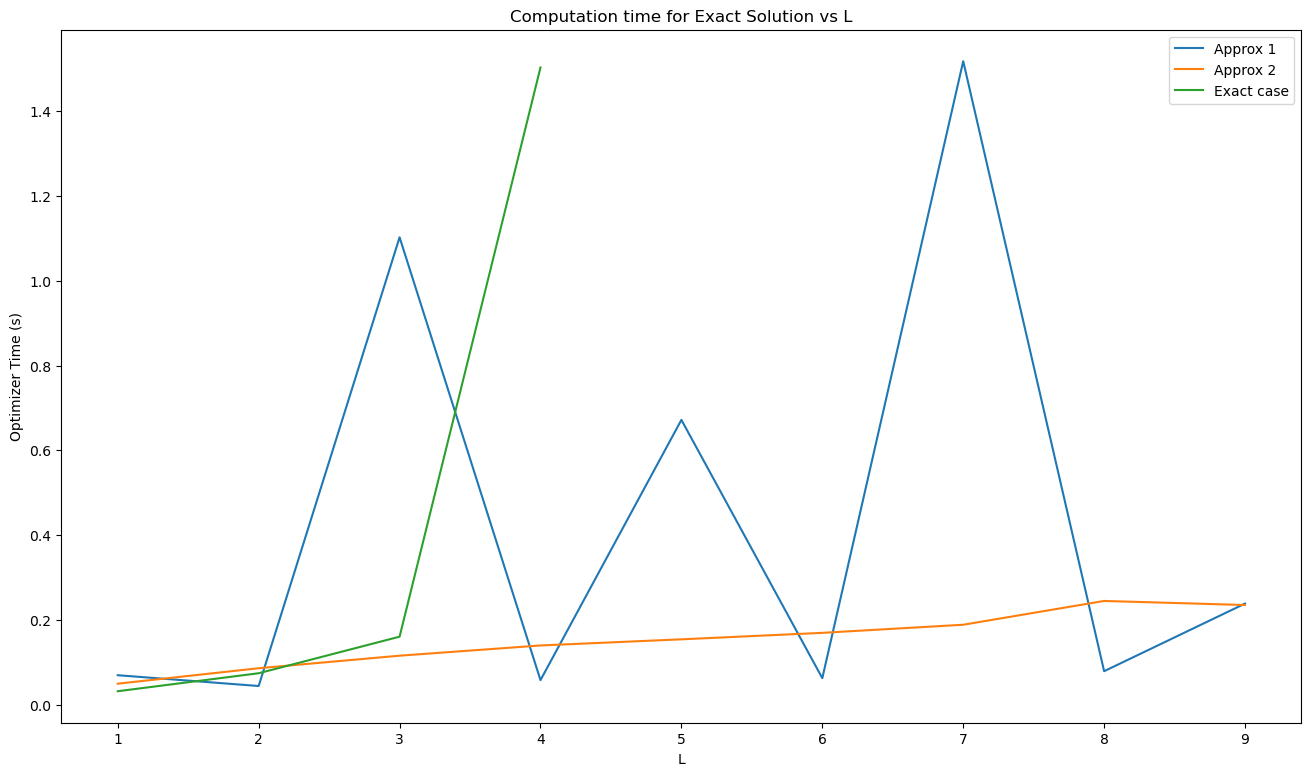

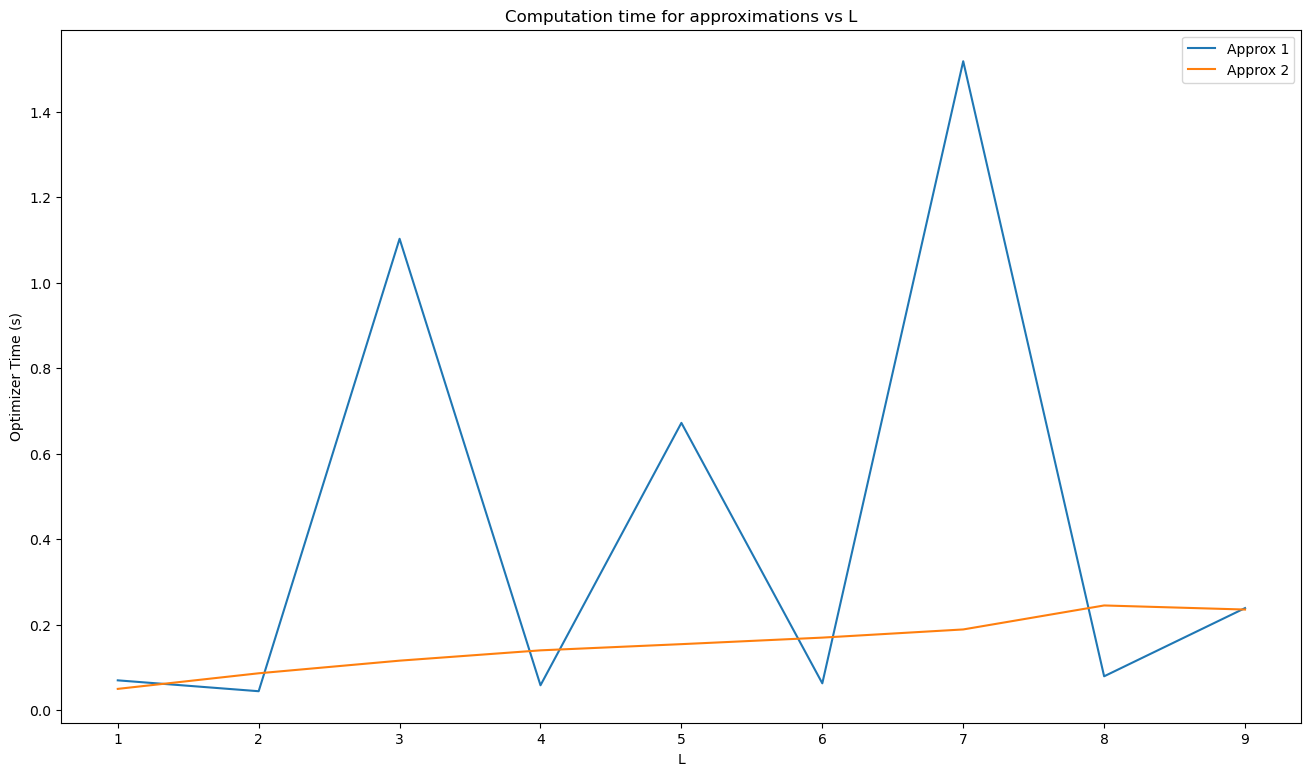

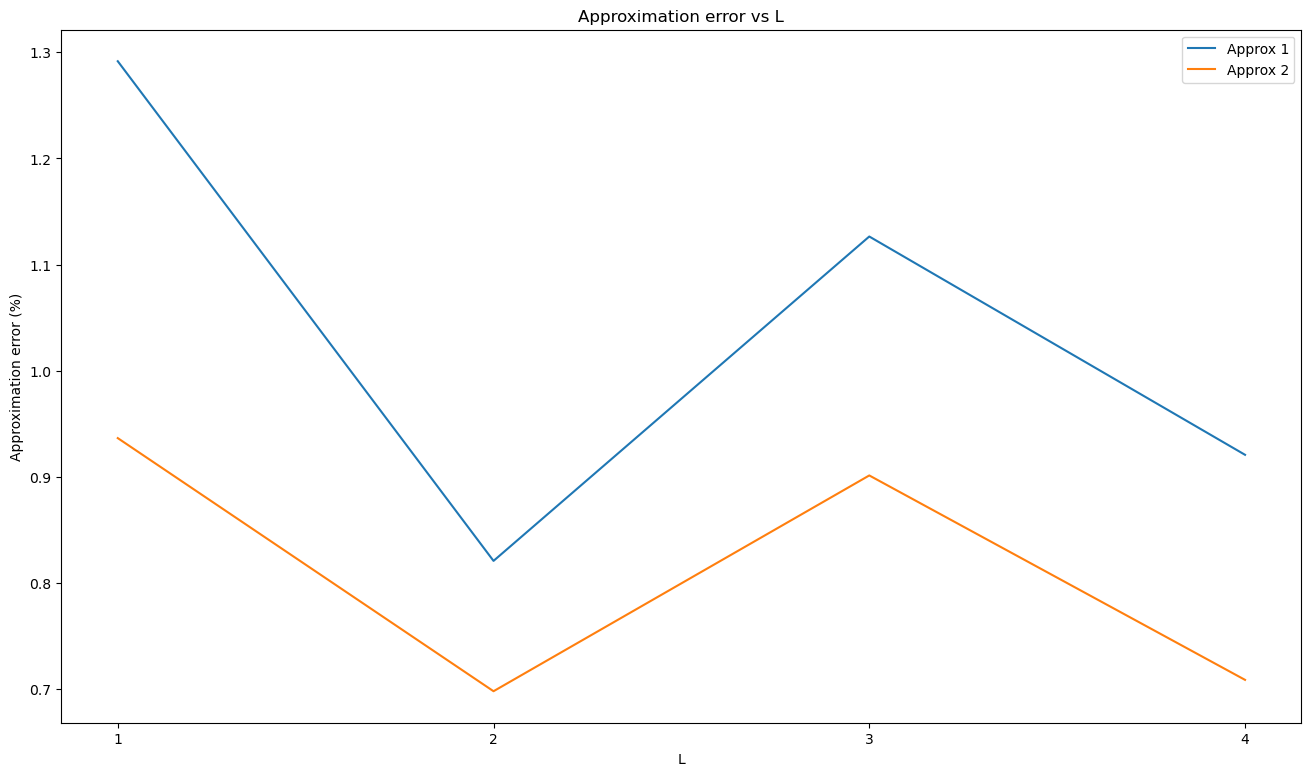

In [11]:
#Plot for the computation time of the exact case.
L_exact_comp = np.arange(1,len(Ex)+1,1)
L_comp = np.arange(1,L_max,1)
plt.plot(L_comp,App1[0:(L_max-1),1],label='Approx 1')
plt.plot(L_comp,App2[0:(L_max-1),1],label='Approx 2')
plt.plot(L_exact_comp,Ex[:,1],label='Exact case')
plt.legend()
plt.xlabel('L')
plt.xticks(L_comp)
plt.ylabel('Optimizer Time (s)')
plt.title('Computation time for Exact Solution vs L')
plt.show()
plt.close()

#Plot for the computation times of the approximations.

plt.plot(L_comp,App1[0:(L_max-1),1],label='Approx 1')
plt.plot(L_comp,App2[0:(L_max-1),1],label='Approx 2')
plt.legend()
plt.xlabel('L')
plt.xticks(L_comp)
plt.ylabel('Optimizer Time (s)')
plt.title('Computation time for approximations vs L')
plt.show()
plt.close()

#Error in the approximation vs L
L_err = np.arange(1,tExact+1,1)
error1 = 100*((np.exp(App1[0:tExact,0])/np.exp(Ex[0:tExact,0]))-1)
error2 = 100*((np.exp(App2[0:tExact,0])/np.exp(Ex[0:tExact,0]))-1)
plt.plot(L_err,error1,label='Approx 1')
plt.plot(L_err,error2,label='Approx 2')
plt.legend()
plt.xlabel('L')
plt.xticks(L_err)
plt.ylabel('Approximation error (%)')
plt.title('Approximation error vs L')
plt.show()
plt.close()

# More results

Results from an extended run of the above experiment are shown below. They were performed on a desktop with 15.6 GB of RAM and an Intel$^{\circledR}$ Core$^{\text{TM}}$ i7-6770HQ CPU @ 2.6 GHz $\times$ 8.

![](fullrun1.png)
![](fullrun2.png)
![](fullrun3.png)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 